# Projet Music Trend Analyser - Python pour la data science

### Auteurs : Nathan SOARES DE MELO & Enrique ALARCON VILLARROEL

L'objectif de ce notebook est d'effectuer une analyse puis une modélisation sur la base de données concernant les 200 chansons les plus populaires du moment. Le projet se déroule en trois phases: 
- <ins>Récupération et traitement des données:</ins> en utilisant le site [Billboard](https://www.billboard.com/charts/billboard-global-200/) pour récupérer les données des 200 chansons les plus populaires du moment, puis les API de MusicBrainz et Genius pour récupérer des informations supplémentaires sur les artistes et les chansons.
- <ins>Analyse des données:</ins> en utilisant des graphiques et des statistiques pour comprendre les tendances et les relations entre les différentes variables.
- <ins>Modélisation:</ins> en utilisant des modèles afin de déterminer d'une part le sentiment général des chansons et d'autre part les paroles les plus populaires.

## Installations préalables

Avant d'exécuter veuillez procéder aux installations de modules nécessaires au bon fonctionnement du code en exécutant la cellule ci-dessous.

In [ ]:
#Installations préalables
%pip install lxml
%pip install pandas
%pip install geopandas
%pip install matplotlib
%pip install requests
%pip install bs4
%pip install nltk
%pip install seaborn
%pip install plotly
%pip install tqdm
%pip install pywaffle
%pip install spacy
%pip install plotnine
%pip install great_tables
%pip install wordcloud
%pip install country_converter
%pip install nbformat
%pip install transformers

## Importation des librairies et des fonctions utiles

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import country_converter as coco
import plotly.express as px
import seaborn as sns
import os
from collections import Counter
from wordcloud import WordCloud
import spacy

%run "src/scripts/billboards.py"
%run "src/scripts/musicbrainz.py"
%run "src/scripts/genius.py"
%run "src/scripts/nltk_script.py"


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Partie 1: Collecte, manipulation et traitement des données

Dans un premier temps, nous récupérons les données du site Billboard en effectuant du scrapping à l'aide des bibliothèques `lxml` et `urllib.request`. Cette étape nous permet de collecter les informations de base sur les 200 chansons les plus populaires du moment. Ces données sont stockées dans un DataFrame `dataframe` qui contient les colonnes suivantes:
- `Song`: le nom de la chanson (string)
- `Artist`: le nom de l'artiste (list of strings)

Les musiques sont ordonnées par popularité, la première musique étant la plus populaire.

<span style="color:red">**Attention:**</span> Il est possible que le site Billboard change de structure, ce qui pourrait entraîner des erreurs lors de l'exécution du code. Dans ce cas, cette étape peut être ignorée mais il faudra par la suite utiliser les données fournies dans le dossier `data` pour continuer le projet.

In [3]:
from src.scripts.billboards import get_billboard_hits
dataframe = get_billboard_hits()

# Flatten the list of artists
all_artists = [artist for sublist in dataframe['Artist'] for artist in sublist]

# Count the occurrences of each artist
artist_counts = pd.Series(all_artists).value_counts()

dataframe

,Song,Artist
0,APT.,"[Rosé, Bruno Mars]"
1,All I Want For Christmas Is You,[Mariah Carey]
2,Last Christmas,[Wham!]
3,Die With A Smile,"[Lady Gaga, Bruno Mars]"
4,Rockin' Around The Christmas Tree,[Brenda Lee]
...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]"
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R..."
197,Counting Stars,[OneRepublic]
198,Lovely,"[Billie Eilish, Khalid]"


On peut d'ores et déjà faire quelques analyses basiques sur ces données. Par exemple, on peut compter le nombre de fois où chaque artiste apparaît dans le top 200, afin de déterminer les artistes les plus populaires du moment. On remarque alors qu'Ariana Grande et Kendrick Lamar sont les artistes les plus populaires, avec tous les deux 8 chansons dans le top 200. 

<span>&#9888;</span>
**Il est possible que les données récupérées ne soient pas à jour, car elles dépendent du site Billboard qui est fréquemment actualisé.**

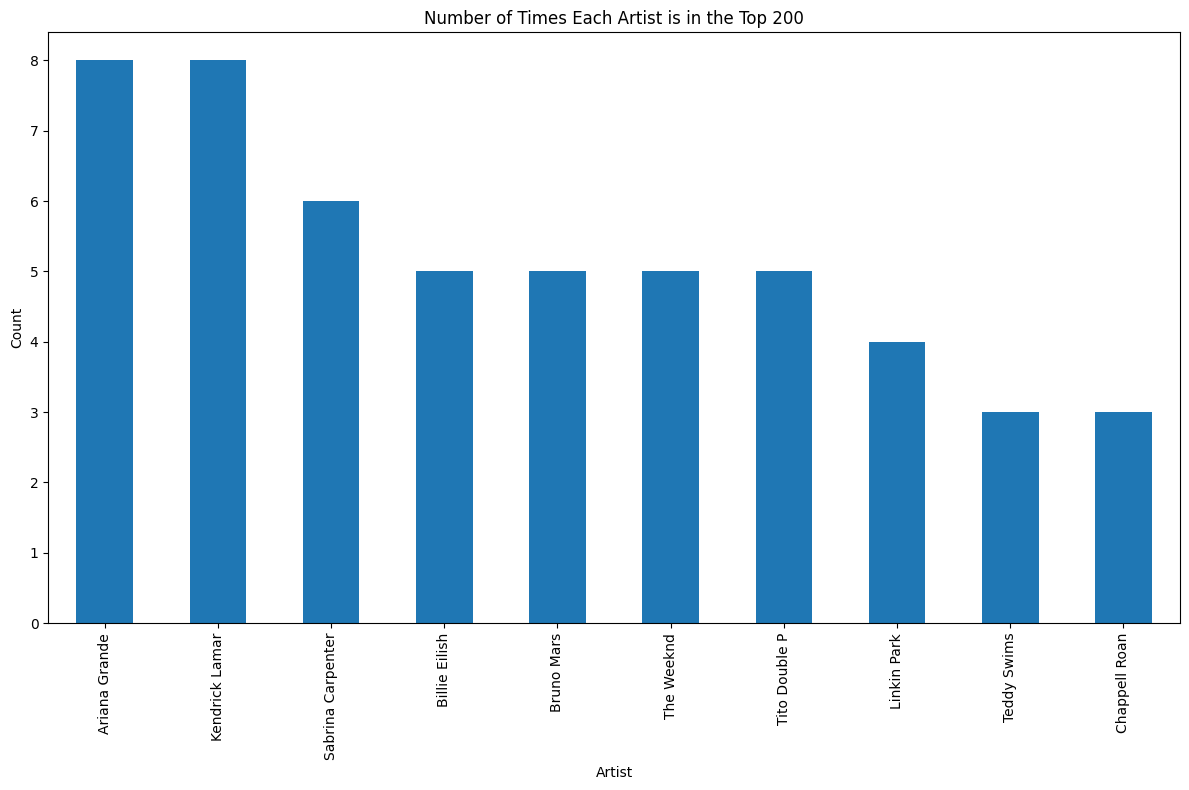

In [4]:
# Plot the data
plt.figure(figsize=(12, 8))
artist_counts.head(10).plot(kind='bar')
plt.title('Number of Times Each Artist is in the Top 200')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Comme nos données sont pour l'instant trop pauvres pour effectuer une analyse plus poussée, nous allons récupérer des informations supplémentaires sur les artistes et les chansons en utilisant les API de MusicBrainz et Genius.
Dans un premier temps, nous allons récupérer les informations sur les artistes en utilisant l'API de MusicBrainz. Pour cela, nous avons créé une fonction `fetch_artist_data` qui prend en entrée une liste d'artistes et renvoie un DataFrame contenant les informations suivantes:
- `Artist`: le nom de l'artiste (string)
- `Country`: le pays d'origine de l'artiste (string, convention ISO 3166-1 alpha-2 avec 2 lettres)
- `Type`: le type de l'artiste (string, "Person" ou "Group")
- `Gender`: le genre de l'artiste (string)
- `Rating`: le rating de l'artiste (dict, contenant les clés "value" et "votes-count")
- `Tags`: les tags associés à l'artiste (list of dicts, contenant les clés "count" et "name")

Les clés "votes-count" et "count" indiquent le nombre de fois que les utilisateurs de MusicBrainz ont participé à la notation de l'artiste ou du tag.

<span>&#9432;</span>
**Dans la suite, les données sont directement chargées depuis un fichier csv pour éviter un temps d'attente trop long (environ 10min). Si vous souhaitez tester le script de récupération des données, il suffit de les supprimer du dossier `data` et de relancer le script.**

In [5]:
from src.scripts.musicbrainz import fetch_artist_data

file_path = 'data/artists_data.csv'
if os.path.exists(file_path):
    df_artists = pd.read_csv(file_path)
    # Convert the 'Rating' column to a dictionary and 'Tags' column to a list
    df_artists['Rating'] = df_artists['Rating'].apply(lambda x: eval(x))
    df_artists['Tags'] = df_artists['Tags'].apply(lambda x: eval(x))
else:
    df_artists = fetch_artist_data(all_artists)
    df_artists.to_csv(file_path, index=False)

df_artists

,Artist,Country,Type,Gender,Rating,Tags
0,ROSÉ,KR,Person,Female,"{'value': 5, 'votes-count': 1}","[{'count': 2, 'name': 'k-pop'}, {'count': 1, '..."
1,Bruno Mars,US,Person,Male,"{'value': 3.75, 'votes-count': 4}","[{'name': '2010s', 'count': 1}, {'count': 4, '..."
2,Mariah Carey,US,Person,Female,"{'votes-count': 13, 'value': 4.4}","[{'count': 1, 'name': '1990s'}, {'count': 1, '..."
3,Wham!,GB,Group,NaN,"{'value': 4.65, 'votes-count': 3}","[{'name': 'christmas music', 'count': 1}, {'na..."
4,Lady Gaga,US,Person,Female,"{'value': 4.25, 'votes-count': 21}","[{'count': 1, 'name': '2000s'}, {'count': 2, '..."
...,...,...,...,...,...,...
251,OneRepublic,US,Group,NaN,"{'votes-count': 3, 'value': 3}","[{'count': 1, 'name': 'folk pop'}, {'count': 3..."
252,Billie Eilish,US,Person,Female,"{'votes-count': 9, 'value': 3.65}","[{'name': '2010s', 'count': 1}, {'count': 1, '..."
253,Khalid,US,Person,Male,"{'votes-count': 0, 'value': None}","[{'name': 'contemporary r&b', 'count': 3}, {'c..."
254,Metro Boomin,US,Person,Male,"{'value': None, 'votes-count': 0}","[{'count': 3, 'name': 'hip hop'}, {'count': 2,..."


Pour nettoyer les données, nous avons simplifié les colonnes `Rating` et `Tags`. Pour la colonne `Rating`, nous l'avons scindée en deux colonnes `RatingValue` et `RatingCount`. Pour la colonne `Tags`, nous avons extrait les noms des tags pour les stocker dans une liste de strings.

In [6]:
# Divide the 'Rating' column in two (value and count)
df_artists['RatingValue'] = df_artists['Rating'].apply(lambda x: x.get('value') if x else None)
df_artists['RatingCount'] = df_artists['Rating'].apply(lambda x: x.get('votes-count') if x else None)

# Remove the 'Rating' column
df_artists.drop(columns=['Rating'], inplace=True)

# Simplify the 'Tags' column (keep only the names)
df_artists['Tags'] = df_artists['Tags'].apply(lambda x: [tag['name'] for tag in x] if x else None)

df_artists

,Artist,Country,Type,Gender,Tags,RatingValue,RatingCount
0,ROSÉ,KR,Person,Female,"[k-pop, korean ballad]",5.00,1
1,Bruno Mars,US,Person,Male,"[2010s, funk, music for soccer moms, pop, r&b,...",3.75,4
2,Mariah Carey,US,Person,Female,"[1990s, 2000s, 90s, adult contemporary, christ...",4.40,13
3,Wham!,GB,Group,NaN,"[christmas music, dance-pop, pop, queer]",4.65,3
4,Lady Gaga,US,Person,Female,"[2000s, 2010s, 2020s, adult contemporary, amer...",4.25,21
...,...,...,...,...,...,...,...
251,OneRepublic,US,Group,NaN,"[folk pop, pop, pop rock, rock]",3.00,3
252,Billie Eilish,US,Person,Female,"[2010s, 2020s, alt-pop, alternative pop, alter...",3.65,9
253,Khalid,US,Person,Male,"[contemporary r&b, hip hop, leftfield, pop, r&...",NaN,0
254,Metro Boomin,US,Person,Male,"[hip hop, trap]",NaN,0


Maintenant, nous souhaitons concaténer les données des artistes avec les données sur le nombre d'apparition dans le top 200. Pour cela, nous utilisons la fonction `merge` de la librairie `pandas` pour fusionner les deux DataFrames sur la colonne `Artist`. Nous pouvons ainsi détecter les artistes mal reconnus par MusicBrainz, car ils n'ont pas de valeur `Count` associée.

De plus, nous en profitons également pour supprimer les doublons dans le DataFrame final, à l'aide de la fonction `drop_duplicates`.

In [7]:
# Merge the two dataframes (df_artists and artist_counts)
df_merged = pd.merge(df_artists, artist_counts, left_on='Artist', right_index=True, how='inner')

# Remove lines with missing values for the 'count' column (remove mismatched artists)
df_merged.dropna(subset=['count'], inplace=True)

# Remove duplicate artists
df_merged.drop_duplicates(subset=['Artist'], inplace=True)

df_merged

,Artist,Country,Type,Gender,Tags,RatingValue,RatingCount,count
1,Bruno Mars,US,Person,Male,"[2010s, funk, music for soccer moms, pop, r&b,...",3.75,4,5
2,Mariah Carey,US,Person,Female,"[1990s, 2000s, 90s, adult contemporary, christ...",4.40,13,2
3,Wham!,GB,Group,NaN,"[christmas music, dance-pop, pop, queer]",4.65,3,1
4,Lady Gaga,US,Person,Female,"[2000s, 2010s, 2020s, adult contemporary, amer...",4.25,21,1
6,Brenda Lee,NaN,Person,Female,"[2008 universal fire victim, american, classic...",4.50,2,1
...,...,...,...,...,...,...,...,...
245,Harry Styles,NaN,Person,Male,"[2020s, funk, new wave, nuno, pop, rock, soft ...",5.00,1,1
246,The Chainsmokers,US,Group,NaN,"[2010s, dance-pop, edm, electro house, electro...",4.50,2,1
250,Roddy Ricch,US,Person,Male,"[english, hip hop, rap, trap]",NaN,0,1
251,OneRepublic,US,Group,NaN,"[folk pop, pop, pop rock, rock]",3.00,3,1


## Partie 2: Analyse descriptive des données 

### A) Analyse générale des tendances

Nous avons désormais des données plus complètes. On peut par exemple afficher le nombre de chansons faites par des groupes ou des personnes, ou encore le genre des artistes les plus populaires.

On remarque que la majorité des artistes sont des hommes (qui ne font pas partie d'un groupe).

In [8]:
# Print the number of groups and solo artists
print("Number of groups:", df_merged[df_merged['Type'] == 'Group'].shape[0])
print("Number of solo artists:", df_merged[df_merged['Type'] == 'Person'].shape[0])
print("Percentage of solo artists:", df_merged[df_merged['Type'] == 'Person'].shape[0] / df_merged.dropna(subset=['Type']).shape[0] * 100)

print("====================================")

# Print the number of male and female artists
print("Number of male artists:", df_merged[df_merged['Gender'] == 'Male'].shape[0])
print("Number of female artists:", df_merged[df_merged['Gender'] == 'Female'].shape[0])
print("Percentage of male artists:", df_merged[df_merged['Gender'] == 'Male'].shape[0] / df_merged.dropna(subset=['Gender']).shape[0] * 100)

Number of groups: 31
Number of solo artists: 107
Percentage of solo artists: 77.53623188405797
Number of male artists: 73
Number of female artists: 32
Percentage of male artists: 68.86792452830188


A partir des données récupérées, nous pouvons également afficher un graphique montrant la répartition des artistes par pays. Nous avons utilisé la bibliothèque `plotly.express` pour créer un graphique interactif qui permet de voir le nombre d'artistes par pays en passant la souris sur la carte. Cependant, comme cette librairie utilise une convention ISO-3 pour les pays, nous avons dû convertir les codes ISO-2 en ISO-3 en utilisant la librairie `country_converter` (`coco`).

In [9]:
# Count the number of artists per country
country_counts = df_merged['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

cc = coco.CountryConverter()
country_counts['Country'] = country_counts['Country'].apply(lambda x: cc.convert(names=x, to='ISO3'))

# Create a choropleth map
fig = px.choropleth(country_counts, 
                    locations="Country", 
                    locationmode="ISO-3", 
                    color="Count", 
                    hover_name="Country", 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Number of Artists per Country")

fig.show()

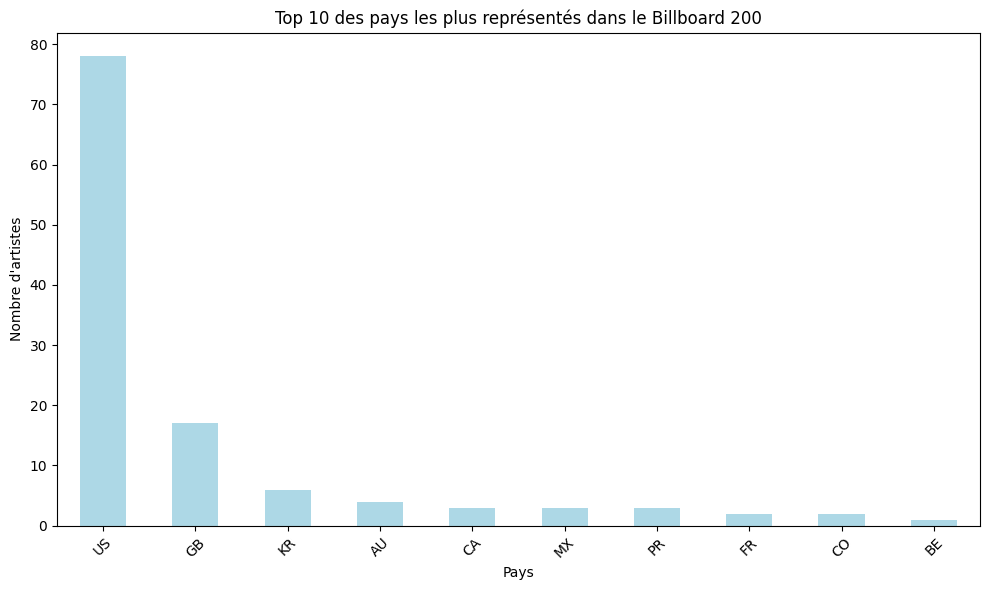

In [10]:
# Les 10 pays les plus représentés
country_counts = df_merged['Country'].value_counts().head(10)  

# Histogramme
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='lightblue')
plt.title('Top 10 des pays les plus représentés dans le Billboard 200')
plt.xlabel('Pays')
plt.ylabel('Nombre d\'artistes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Nous pouvons également nous intéresser aux notes obtenues par les artistes. Comme on le voit sur le graphique, elles sont globalement très positives, ce qui est cohérent avec le fait que les artistes les plus populaires sont généralement bien notés.

En effet, sur l'axe des abscisses nous représentons les notes obtenues entre 3 et 5 et les fréquences de distribution sur celui des ordonnées. Nous avons également implanté une courbe bleue qui est destinée à illustrer la tendance générale. A première vue, la distribution est asymétrique. Ainsi les notes des artistes figurant dans le classement sont principalement élevées : la majorité des artistes ont des notes comprises entre 3,75 et 5.

La note moyenne des artistes du  classement est de 4,3 (avec un écart-type faible de 0,59). Cela signifie que les artistes qui sont classés tendent à être bien notés, et le pic autour de 5 reflète que les artistes obtiennent des notes parfaites (ou presque). En revanche, il y a très peu d'artistes avec des notes inférieures à 3.5 : les artistes les plus mal notés n'atteigent pas le Billboard 200. Cet histogramme permet donc d'établir une forte corrélation entre les notes des artistes et leur succès commercial. 

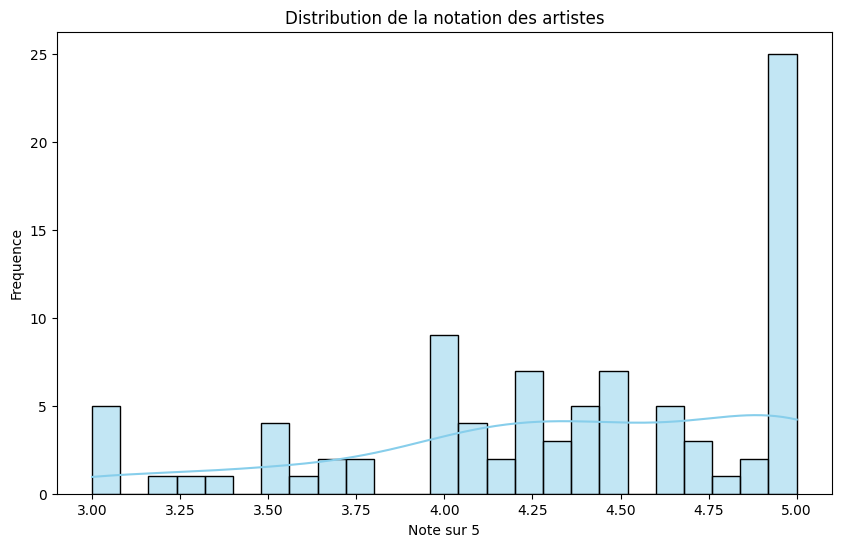

Moyenne de la notation des artistes: 4.344444444444444
Ecart-type de la notation des artistes: 0.5968759702360227


In [11]:
# Histogramme des RatingValue
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['RatingValue'].dropna(), kde=True, bins=25, color='skyblue')
plt.title('Distribution de la notation des artistes')
plt.xlabel('Note sur 5')
plt.ylabel('Frequence')
plt.show()

# Affichage de la moyenne et de l'écart-type
print("Moyenne de la notation des artistes:", df_merged['RatingValue'].mean())
print("Ecart-type de la notation des artistes:", df_merged['RatingValue'].std())



Nous avons vu en début de partie que la majorité des artistes sont des hommes qui ne font pas partie d'un groupe. Rentrons plus en détail dans cette analyse avec visualisation et une représentation graphique des résultats.

Nous avons effectué deux représentations: d'une part un diagramme à barres comparant la fréquence des solistes et des groupes dans les classement, et d'autre part une box plot affichant la distribution des notes pour les deux groupes (avec les notes comprises entre 3 et 5 comme dans l'analyse précédente).

Nous observons que les solistes sont significativement plus nombreux que les groupes dans le Billboard 200: grâce au diagramme à barres nous constatons que la proportion des solistes est environ 3.5 fois plus élevée que celle des groupes. Néanmoins, la boxplot permet d'établir un point commun entre les deux groupes (et donc une caractéristique qu'on a étudié auparavant): les distributions des notes sont très similaires entre les deux types d'artistes. Par conséquent, cette analyse confirme bien (et c'est plutôt rassurant) que la qualité d'une chanson n'est pas liée au fait qu'un artiste la produise individuellement ou avec un groupe. Enfin les artistes solo ont un écart-intercartile plus élevé, mais cela est dû au nombre plus élevé des solistes dans le classement. 

Ainsi à travers cette analyse, nous pouvons conclure que l'industrie musicale favorise les artistes solo dans le classement, mais les groupes (en dépit de leur faible nombre par rapport aux solistes) ont des notes comparables: Ainsi le succès dépend davantage du talent et de la popularité de l'artiste, qu'il soit en solo ou en groupe. S'il y a plus de solistes, c'est probablement dû à des raisons de logistique (plus facile de produire une chanson quand on est tout seul, car le choix des chansons dépendent de moins de monde par exemple).

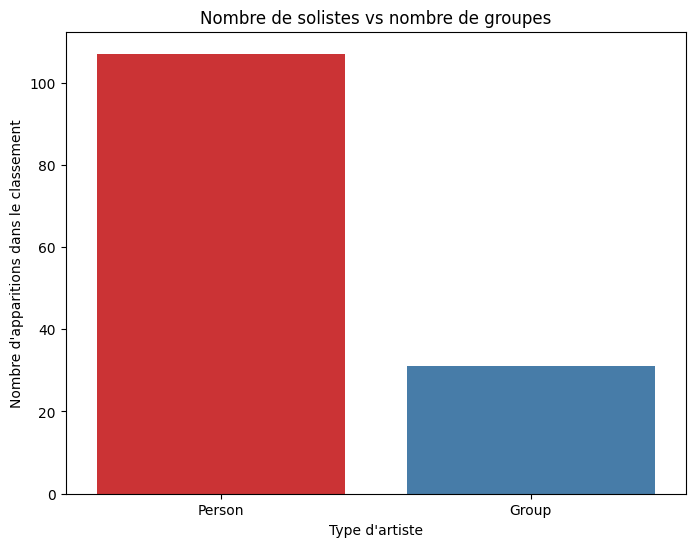

In [12]:
# On compte le nombre de groupes et de solistes
type_counts = df_merged['Type'].value_counts()

# Le diagramme a barres
plt.figure(figsize=(8, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.index,  # Assign x to hue
    palette="Set1", dodge=False)
plt.title('Nombre de solistes vs nombre de groupes')
plt.xlabel("Type d'artiste")
plt.ylabel("Nombre d'apparitions dans le classement")
plt.show()


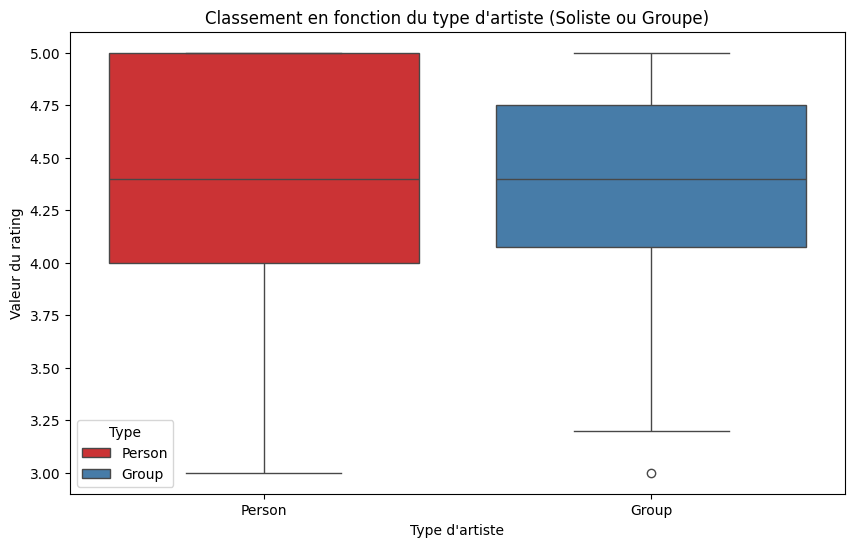

In [13]:
# Box plot pour le type d'artiste
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='RatingValue', data=df_merged, hue='Type', palette="Set1",dodge=False)
plt.title("Classement en fonction du type d'artiste (Soliste ou Groupe)")
plt.xlabel("Type d'artiste")
plt.ylabel('Valeur du rating')
plt.show()


Un raisonnement similaire peut être établi lorsque l'on se penche sur le genre de l'artiste. 

Tout d'abord nous constatons une disparité de genre très marquée dans le classement: parmi les solistes, environ 70 des artistes sont masculins contre 32 pour les femmes et seulement 1-2 artistes non binaires. 

Les boxplots permettent de voir que malgré ce déséquilibre, les répartitions des notes obtenues sont similaires entre les artistes masculines et féminins (moyennes de 4,5 et 4,25 respectivement). D'autre part, les artistes féminines ont une distributions de notes plus concentrée que celle des hommes. 

Nous ne pouvons pas établir de conclusion significative pour les artistes non binaires de par leur faible nombre dans le classement. 

La conclusion est en quelque sorte similaire à l'analyse précédente: la qualité des notes entre les genres les plus réprésentés est comparable. Les hommes sont plus présents dans les classement mais cette surreprésentation n'est pas due à leur qualité en tant qu'artistes. Cela peut s'expliquer par des facteurs externes qui ne sont pas visibles dans les classements: par exemple, les hommes du classement ont probablement plus de contacts, ressources pour produire leurs chansons- NB: nous ne ferons pas une analyse de ces facteurs parce que cela ne fait pas partie de notre champ d'étude. 

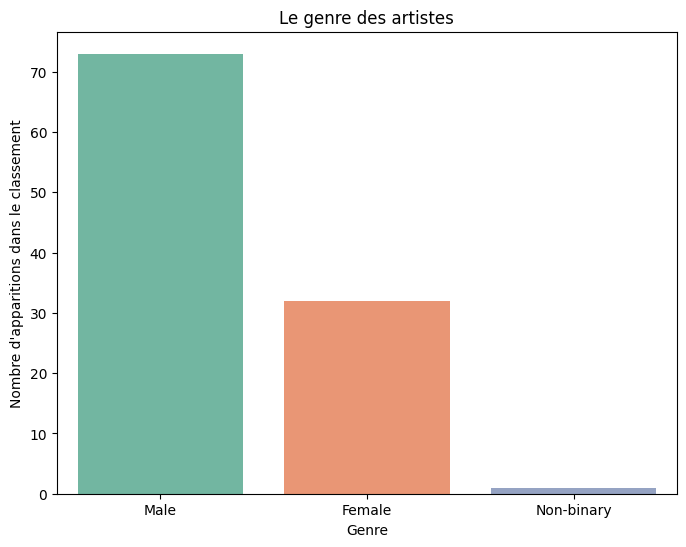

In [14]:
# Le genre des artistes
gender_counts = df_merged['Gender'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, hue=gender_counts.index,palette="Set2", dodge=False)
plt.title('Le genre des artistes')
plt.xlabel('Genre')
plt.ylabel("Nombre d'apparitions dans le classement")
plt.show()


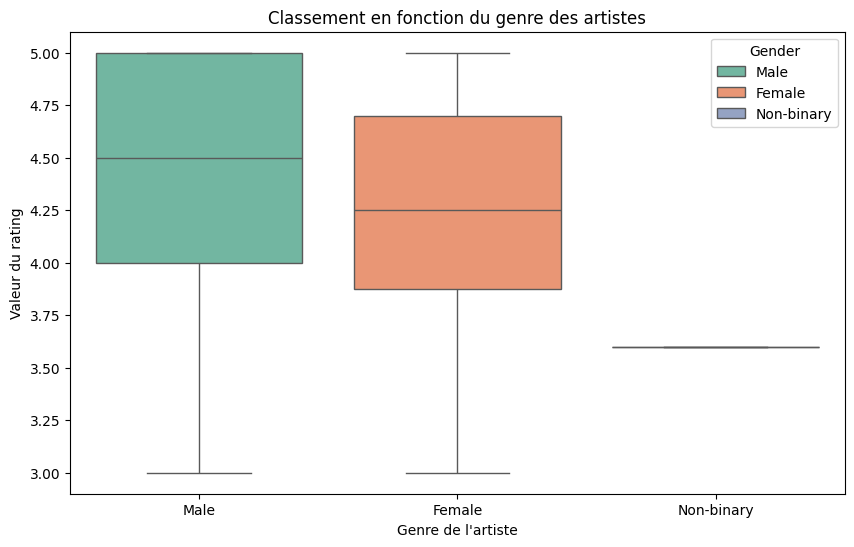

In [15]:
# Box plot pour le genre de l'artiste
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='RatingValue', data=df_merged, hue='Gender', palette="Set2", dodge=False)
plt.title("Classement en fonction du genre des artistes")
plt.xlabel("Genre de l'artiste")
plt.ylabel('Valeur du rating')
plt.show()

### B) Analyse approfondie des paroles

#### i) Collecte des paroles des chansons du Billboard 200

Pour finir de compléter notre dataset, nous allons récupérer les paroles des chansons en utilisant l'API de Genius. Pour cela, nous avons créé une fonction `fetch_lyrics` qui prend en entrée un DataFrame contenant les chansons et les artistes, et renvoie un DataFrame contenant une nouvelle colonne `Lyrics` qui contient les paroles des chansons.

In [16]:
from src.scripts.genius import fetch_lyrics

output_path = 'data/lyrics_data.csv'
if os.path.exists(output_path):
    dataframe = pd.read_csv(output_path)
    # Convert the 'Artist' column to a list
    dataframe['Artist'] = dataframe['Artist'].apply(lambda x: eval(x))
else:
    dataframe = fetch_lyrics(dataframe)
    dataframe.to_csv(output_path, index=False)
    
dataframe

,Song,Artist,Lyrics
0,APT.,"[Rosé, Bruno Mars]",\r\nChaeyoung-iga\r\n joahaneun\r\nRandom game...
1,All I Want For Christmas Is You,[Mariah Carey],\r\nI don't want a lot for Christmas\r\nThere ...
2,Last Christmas,[Wham!],"\r\n\r\nAh, ah-ah\r\nOoh-woah\r\nOh-oh\r\n\r\n..."
3,Die With A Smile,"[Lady Gaga, Bruno Mars]","\r\n\r\n\r\nI, I just woke up from a dream\r\n..."
4,Rockin' Around The Christmas Tree,[Brenda Lee],\r\nRockin' around the Christmas tree\r\nAt th...
...,...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]","\r\nI've been reading books of old, the legend..."
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R...","\r\nOoh\r\nOoh\r\n\r\nWhite diamonds, 2 a.m., ..."
197,Counting Stars,[OneRepublic],"\r\nLately, I've been, I've been losin' sleep\..."
198,Lovely,"[Billie Eilish, Khalid]",\r\nThought I found a way\r\nThought I found a...


Dans le fichier `src/scripts/nltk_script.py`, nous avons créé une méthode `tokenize_lyrics` qui peut être appliquée à un DataFrame pour tokeniser les paroles des chansons. Cette méthode utilise la librairie `nltk` pour tokeniser les paroles, et plus précisément la méthode `word_tokenize`. Cette méthode permet également de filtrer les stopwords, c'est-à-dire les mots qui n'apportent pas de sens à la phrase (comme "the", "and", "or", etc.).

Depuis `nltk.corpus`, nous avons importé la liste des stopwords en anglais, en français et en espagnol. Nous avons également ajouté quelques mots à la liste des stopwords, car ils apparaissaient fréquemment dans les paroles des chansons et n'apportaient pas de sens à la phrase (comme 'oh', 'na', 'yeah', 'uh', 'ah', etc.).

Ensuite, nous avons pu créer un DataFrame contenant les mots les plus fréquents dans les paroles des chansons. Pour cela, nous avons utilisé la méthode `Counter` de la librairie `collections` pour compter le nombre d'occurrences de chaque mot dans les paroles. Nous avons ensuite affiché les 20 mots les plus fréquents dans les paroles des chansons.

In [17]:
from src.scripts.nltk_script import tokenize_lyrics
from src.scripts.nltk_script import tokenize_lyrics_with_stopwords




# Tokenize the lyrics
dataframe['LyricsTokenizedStopWords'] = dataframe['Lyrics'].apply(tokenize_lyrics_with_stopwords)
dataframe['LyricsTokenized'] = dataframe['Lyrics'].apply(tokenize_lyrics)

# Count the occurrences of each word
word_counts_stop_words = Counter([word for sublist in dataframe['LyricsTokenizedStopWords'] for word in sublist])
word_counts = Counter([word for sublist in dataframe['LyricsTokenized'] for word in sublist])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### ii) Analyse descriptive et fréquentielle des paroles

Nous pouvons désormais représenter les mots les plus fréquents dans les paroles des chansons en utilisant un nuage de mots. Pour cela, nous avons utilisé la librairie `wordcloud` pour créer un nuage de mots qui permet de visualiser les mots les plus fréquents dans les paroles des chansons. Plus un mot est fréquent, plus il est grand dans le nuage de mots.

On remarque l'utilité d'enlever les stopwords, car sinon les mots les plus fréquents seraient des mots comme "the", "and", "or", etc., qui n'apportent pas de sens à la phrase. Dans le deuxième nuage de mots, on voit que les mots les plus fréquents sont des mots qui apportent un sens à la phrase, comme "love", "baby", "christmas", "like", etc.

De plus, étant dans la période de Noël, on peut voir que le mot "christmas" est très fréquent dans les paroles des chansons. D'autres mots rattachés à Noël, comme "santa", "tree", "merry", "snow", etc., sont également fréquents dans les paroles des chansons.

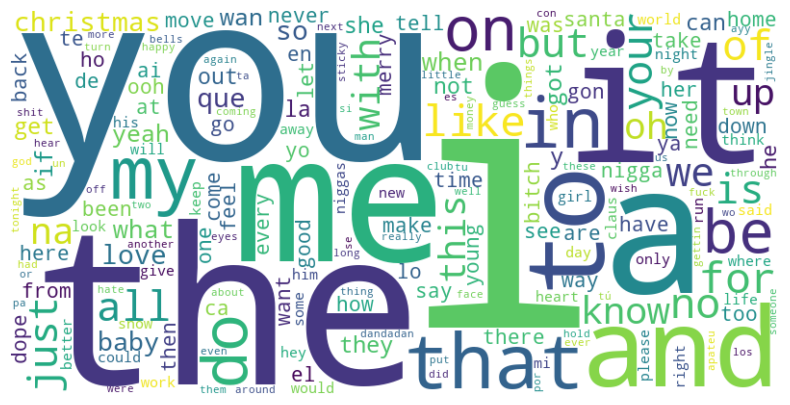

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_counts_stop_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

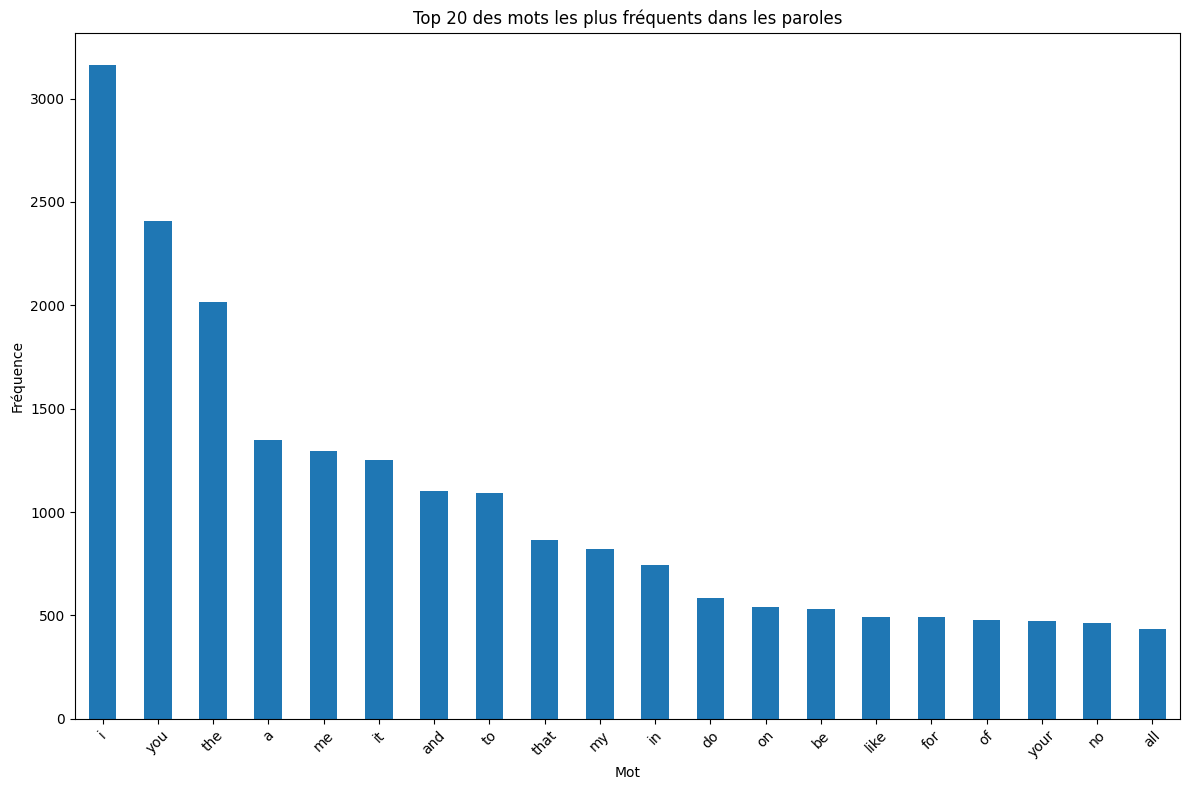

In [19]:
# Histogramme des mots les plus fréquents avec les stop words
plt.figure(figsize=(12, 8))
pd.Series(word_counts_stop_words).sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 des mots les plus fréquents dans les paroles')
plt.xlabel('Mot')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

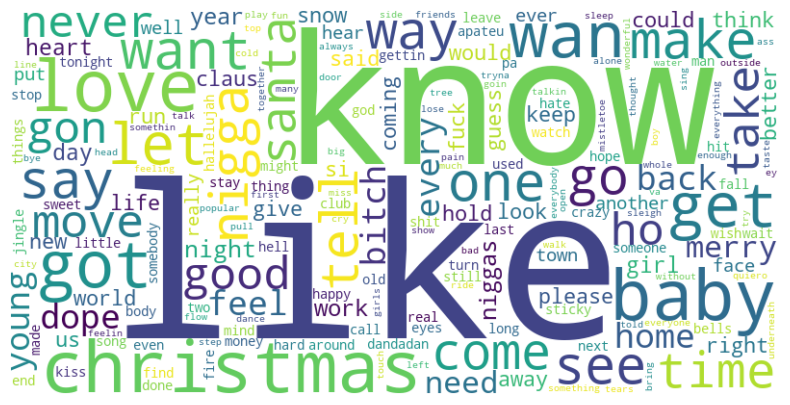

In [20]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

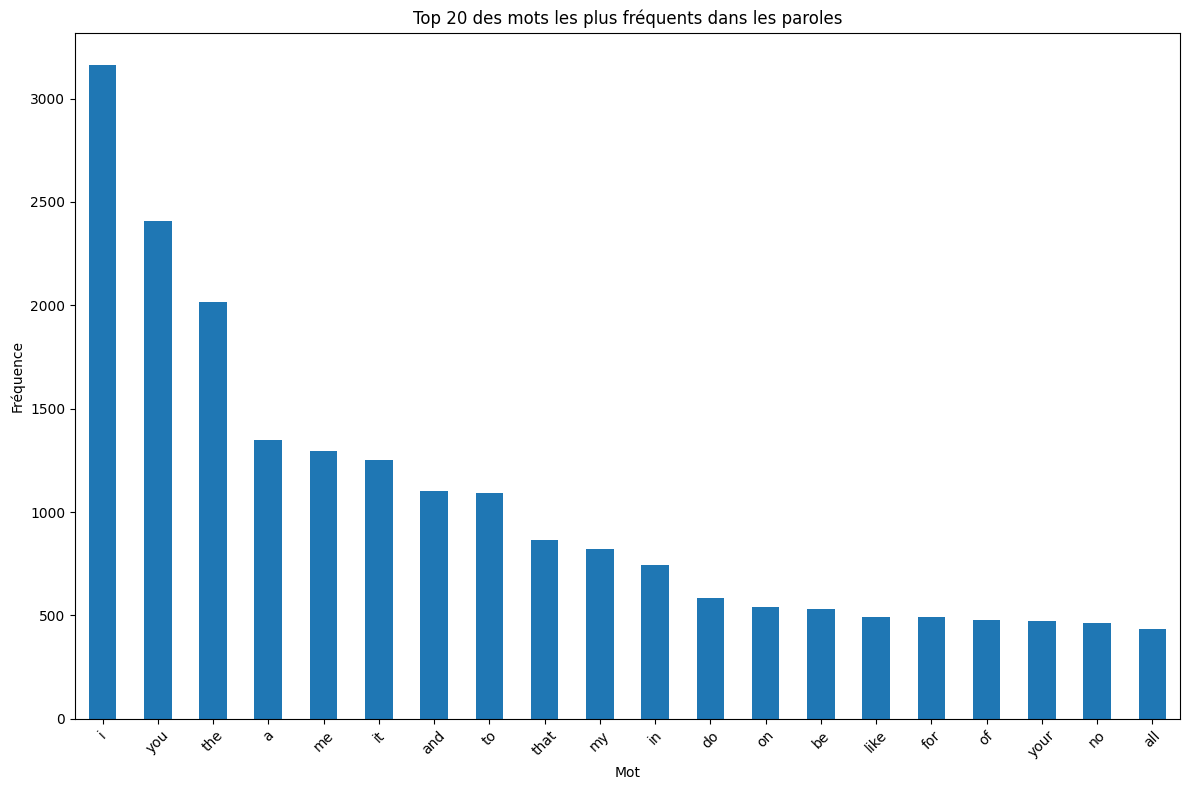

In [21]:
# Histogramme des mots les plus fréquents sans les stop words
plt.figure(figsize=(12, 8))
pd.Series(word_counts_stop_words).sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 des mots les plus fréquents dans les paroles')
plt.xlabel('Mot')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
#Détermination de la durée moyenne des chansons (en termes de mots)
dataframe['LyricsLength'] = dataframe['LyricsTokenizedStopWords'].apply(len)
print("Durée moyenne des chansons en termes de mots:", dataframe['LyricsLength'].mean())

Durée moyenne des chansons en termes de mots: 337.355


#### iii) Vers la lemmatisation des paroles

Enfin nous procédons à l'analyse par lemmatisation avec `spaCy` qui permet d'affiner les résultats précédents, afin d'avoir une vision plus précise de la fréquences de certains thèmes dans le classement du Billboard_200. 

Un détail survient: nous remarquons la présence de mots en espagnol comme "de", "te" ou "el", vu que nous avons uniquement travaillé avec `en_core_web_sm`, les stopwords en Espagnol n'ont pas été éliminés. Néanmoins cela met en évidence une tendance: la présence importante des artistes hispaniques dans les classements en tant que solistes ou en tant que collaborateurs d'autres artistes.

De plus, le thème du désir et de l'intention est plus présent (par exemple en additionnant les occurrences de wanna et want).
Finalement, les verbes d'action comme "come", "tell" et "let" deviennent plus visibles.
 

In [23]:
#Tokenization et nettoyage des paroles avec spaCY
import spacy
!python -m spacy download en_core_web_sm
nlp_english = spacy.load("en_core_web_sm")

#tokenisation
def tokenize_lyrics(lyrics):
    doc = nlp_english(lyrics)  
    tokens = [token.text for token in doc]  
    return tokens

df_freq_analysis=dataframe.copy()
df_freq_analysis['Tokens'] = df_freq_analysis['Lyrics'].apply(tokenize_lyrics)


#Nettoyage
import string
def clean_tokens(tokens):
    cleaned_tokens=[]
    for token in tokens:
        token = token.strip()  
        if token not in {"\n", "\n\n", "\n\n\n"} and token not in string.punctuation:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens
df_freq_analysis

df_freq_analysis['Cleaned_Tokens'] = df_freq_analysis['Tokens'].apply(clean_tokens)



Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 932.9 kB/s eta 0:00:14
     ---- ----------------------------------- 1.3/12.8 MB 1.6 MB/s eta 0:00:08
     ------- -------------------------------- 2.4/12.8 MB 2.3 MB/s eta 0:00:05
     --------- ------------------------------ 3.1/12.8 MB 2.6 MB/s eta 0:00:04
     ------------ --------------------------- 3.9/12.8 MB 2.8 MB/s eta 0:00:04
     ------------- -------------------------- 4.5/12.8 MB 2.8 MB/s eta 0:00:03
     ----------------- ---------------------- 5.5/12.8 MB 3.0 MB/s eta 0:00:03
     -------------------- ------------------- 6.6/12.8 MB 3.2 MB/s eta 0:00:02
 

In [24]:
#Lemmatization (utile pour l'approche bag-of-words)- avec spaCy

# Pour faciliter l'analyse, on cree une Series qui regroupe tous les mots de toutes les chansons
all_words = [word for tokens in df_freq_analysis['Cleaned_Tokens'] for word in tokens]

# Elimination des stopwords
stop_words_english = nlp_english.Defaults.stop_words 
all_words_filtered = [word for word in all_words if word.lower() not in stop_words_english]

def lemmatize_tokens(tokens):
    doc=nlp_english(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]
    return lemmatized_tokens

#Lemmatization des Series all_words et all_words_filtered
all_words_lemmatized = lemmatize_tokens(all_words)
all_words_filtered_lemmatized = lemmatize_tokens(all_words_filtered)

df_freq_analysis['Lemmas'] = df_freq_analysis['Cleaned_Tokens'].apply(lemmatize_tokens)



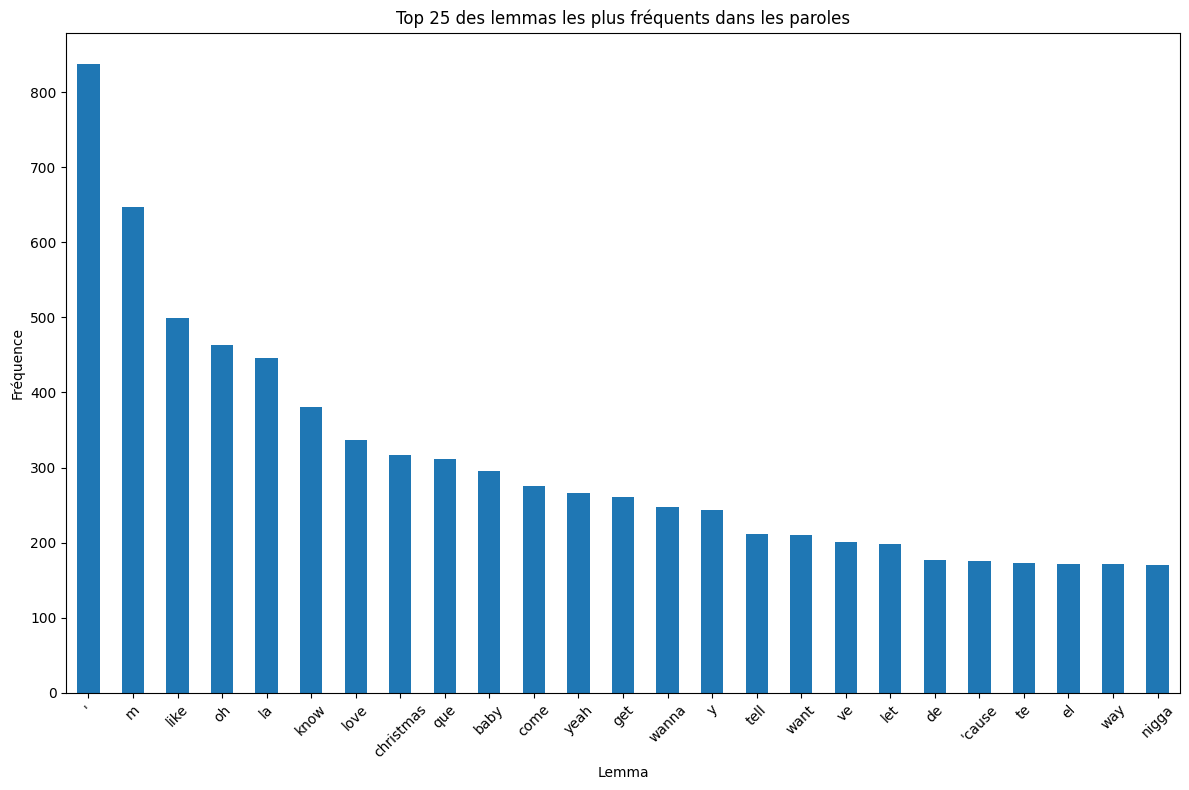

In [25]:
#Un dernier graphique: Les 25 "lemmas" les plus récurrents dans le BillBoard200
plt.figure(figsize=(12, 8))
pd.Series([lemma for sublist in df_freq_analysis['Lemmas'] for lemma in sublist]).value_counts().head(25).plot(kind='bar')
plt.title('Top 25 des lemmas les plus fréquents dans les paroles')
plt.xlabel('Lemma')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


D'après l'étude précédente, les mots qui ressortent le plus sont "love", "like", "know" et "baby". On peut interpréter ceci comme suit :

Tout d'abord, concernant les thèmes principaux :

- La dominance de "love" et de "baby" souligne la présence de thèmes romantiques dans la musique populaire.
- Les mots du langage courant (mots béquilles) comme "know" ou "like" reflètent la volonté des artistes de rendre leurs paroles accessibles afin que le plus grand nombre de personnes puisse s'y identifier (d'où leur présence dans le classement).
- La présence de mots issus de l'argot tels que "bitch", "nigga", "fuck" montre l'influence du rap dans le classement ainsi que la tolérance de ces mots de la part du public.
- Enfin, compte tenu de la saison, le mot "Christmas" est présent.

Le choix de ces mots n'est pas anodin : le style informel et accessible semble captiver davantage les auditeurs.

#### iv) Synthèse du contenu des paroles à l'aide des embeddings

Finalement, pour terminer notre analyse, nous pouvons utiliser la méthode `word embedding` pour représenter les mots les plus fréquents dans les paroles des chansons en deux dimensions. Pour cela, nous avons utilisé la librairie `spacy` pour créer un modèle de word embedding en utilisant le modèle `en_core_web_md`. Nous avons ensuite utilisé ce modèle pour représenter les mots les plus fréquents dans les paroles des chansons en deux dimensions. Nous avons affiché les 50 mots les plus fréquents dans les paroles des chansons en utilisant un graphique en deux dimensions, afin de ne pas surcharger le graphique. On peut ainsi voir les relations entre les mots les plus fréquents dans les paroles des chansons. Les verbes d'action sont regroupés dans le coin inférieur droit, les mots courants (comme "girl", "baby", "smoke", "drink", etc.) sont regroupés au même endroit, au centre du graphique, ce qui montre un champ lexical commun.

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     ---------------------------------------- 0.3/33.5 MB ? eta -:--:--
      --------------------------------------- 0.5/33.5 MB 1.4 MB/s eta 0:00:24
      --------------------------------------- 0.8/33.5 MB 1.2 MB/s eta 0:00:28
     - -------------------------------------- 1.0/33.5 MB 1.2 MB/s eta 0:00:28
     - -------------------------------------- 1.0/33.5 MB 1.2 MB/s eta 0:00:28
     -- ------------------------------------- 2.1/33.5 MB 1.5 MB/s eta 0:00:21
     --- ------------------------------------ 2.9/33.5 MB 1.9 MB/s eta 0:00:17
     ---- ----------------------------------- 3.7/33.5 MB 2.1 MB/s eta 0:00:14
     ----- ---------------------------------- 4.5/33.5 MB 2.4 MB/s eta 0:00:12
     ----- ---------------------------------- 5.0/33.5 MB 2.3 MB/s eta 0:0

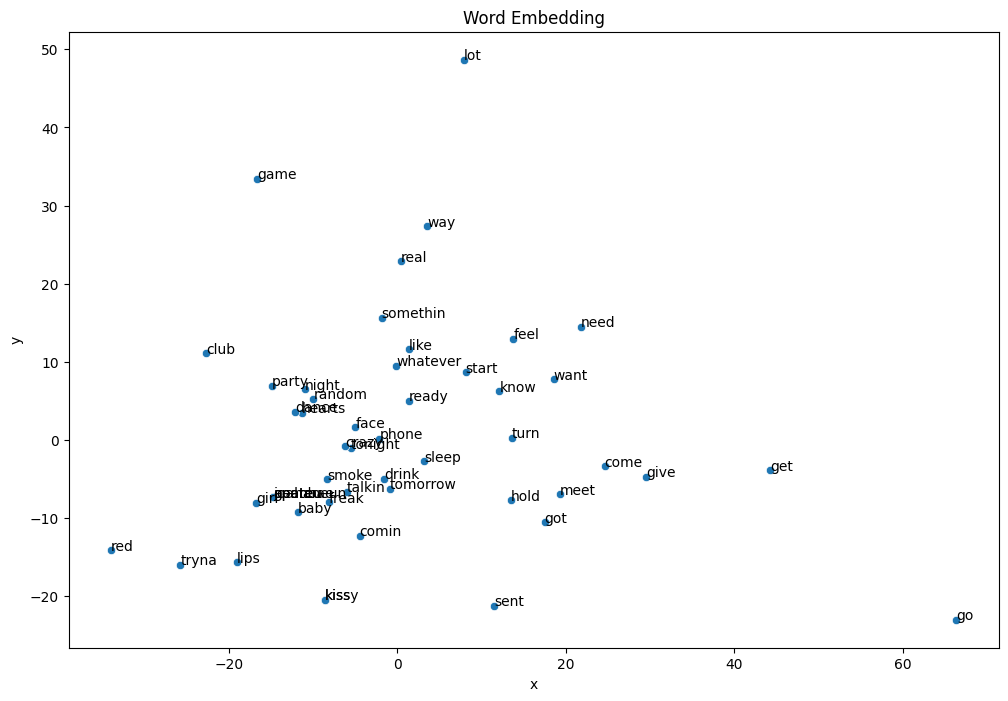

In [109]:
# Word embedding and visualization

# Reduce the dimensionality of the vectors
from sklearn.decomposition import PCA

#Une installation préalable
!python -m spacy download en_core_web_md

# Load the pre-trained model
nlp = spacy.load('en_core_web_md')

# Get the vector for the first 50 words
vectors = [nlp(word).vector for word in list(word_counts.keys())[:50]]

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Create a dataframe
df_vectors = pd.DataFrame(vectors_2d, columns=['x', 'y'])
df_vectors['word'] = list(word_counts.keys())[:50]

# Plot the words with their labels
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_vectors, x='x', y='y')
for i, word in df_vectors.iterrows():
    plt.text(word['x'], word['y'], word['word'])
plt.title('Word Embedding')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Partie 3: Modélisation: vers la création d'un véritable hit

### A) Analyse du sentiment des chansons

Dans un premier temps, intéressons-nous à la prédiction du sentiment général des chansons. Pour cela, nous allons utiliser un modèle de classification pré-entraîné provenant de la librairie `nltk.sentiment.vader`. Ce modèle permet de prédire le sentiment général d'un texte en lui attribuant une note entre -1 (négatif) et 1 (positif). Nous allons appliquer ce modèle aux paroles des chansons pour prédire le sentiment général de chaque chanson.

In [27]:
from src.scripts.nltk_script import analyze_sentiment

# Analyze the sentiment of the lyrics
dataframe['Sentiment'] = dataframe['LyricsTokenized'].apply(analyze_sentiment)

# Divide the sentiment into positive, negative, and neutral
dataframe['Positive'] = dataframe['Sentiment'].apply(lambda x: x['pos'])
dataframe['Negative'] = dataframe['Sentiment'].apply(lambda x: x['neg'])
dataframe['Neutral'] = dataframe['Sentiment'].apply(lambda x: x['neu'])

# Remove the 'Sentiment' column
dataframe.drop(columns=['Sentiment'], inplace=True)

dataframe

,Song,Artist,Lyrics,LyricsTokenizedStopWords,LyricsTokenized,LyricsLength,Positive,Negative,Neutral
0,APT.,"[Rosé, Bruno Mars]",\r\nChaeyoung-iga\r\n joahaneun\r\nRandom game...,"[joahaneun, random, game, random, game, game, ...","[joahaneun, random, game, random, game, game, ...",305,0.206,0.053,0.741
1,All I Want For Christmas Is You,[Mariah Carey],\r\nI don't want a lot for Christmas\r\nThere ...,"[i, do, want, a, lot, for, christmas, there, i...","[want, lot, christmas, one, thing, need, care,...",343,0.327,0.000,0.673
2,Last Christmas,[Wham!],"\r\n\r\nAh, ah-ah\r\nOoh-woah\r\nOh-oh\r\n\r\n...","[ah, last, christmas, i, gave, you, my, heart,...","[last, christmas, gave, heart, next, day, gave...",436,0.308,0.128,0.564
3,Die With A Smile,"[Lady Gaga, Bruno Mars]","\r\n\r\n\r\nI, I just woke up from a dream\r\n...","[i, i, just, woke, up, from, a, dream, where, ...","[woke, dream, say, goodbye, know, means, since...",294,0.317,0.160,0.523
4,Rockin' Around The Christmas Tree,[Brenda Lee],\r\nRockin' around the Christmas tree\r\nAt th...,"[rockin, around, the, christmas, tree, at, the...","[rockin, around, christmas, tree, christmas, p...",116,0.392,0.023,0.585
...,...,...,...,...,...,...,...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]","\r\nI've been reading books of old, the legend...","[i, been, reading, books, of, old, the, legend...","[reading, books, old, legends, myths, achilles...",266,0.429,0.050,0.521
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R...","\r\nOoh\r\nOoh\r\n\r\nWhite diamonds, 2 a.m., ...","[ooh, ooh, white, diamonds, 2, she, wildin, bi...","[white, diamonds, 2, wildin, bitches, sick, go...",298,0.087,0.326,0.587
197,Counting Stars,[OneRepublic],"\r\nLately, I've been, I've been losin' sleep\...","[lately, i, been, i, been, losin, sleep, dream...","[lately, losin, sleep, dreamin, things, could,...",519,0.071,0.103,0.826
198,Lovely,"[Billie Eilish, Khalid]",\r\nThought I found a way\r\nThought I found a...,"[thought, i, found, a, way, thought, i, found,...","[thought, found, way, thought, found, way, nev...",180,0.225,0.155,0.620


On récupère ainsi des informations intéressantes sur les sentiments des chansons. Par exemple, on peut afficher les chansons les plus positives et les chansons les plus négatives du top 200. On peut également afficher la distribution des sentiments des chansons en utilisant un histogramme. On remarque que la tendance est plutôt positive, avec une majorité de chansons ayant un sentiment positif. Cela est cohérent avec le fait que les chansons les plus populaires sont généralement des chansons joyeuses et entraînantes, qui plus est en période de fêtes.

In [28]:
# Mean of the sentiment scores
print(dataframe[['Positive']].mean())
print(dataframe[['Negative']].mean())
print(dataframe[['Neutral']].mean())

# Display the saddest song
saddest_song = dataframe.loc[dataframe['Negative'].idxmax()]
print("Saddest song:", saddest_song['Song'] + " by " + saddest_song['Artist'][0])
print("Score:", saddest_song['Negative'])

# Display the happiest song
happiest_song = dataframe.loc[dataframe['Positive'].idxmax()]
print("Happiest song:", happiest_song['Song'] + " by " + happiest_song['Artist'][0])
print("Score:", happiest_song['Positive'])

Positive    0.23738
dtype: float64
Negative    0.11674
dtype: float64
Neutral    0.64586
dtype: float64
Saddest song: Ma Meilleure Ennemie by Stromae
Score: 0.448
Happiest song: Merry Christmas by Ed Sheeran
Score: 0.646


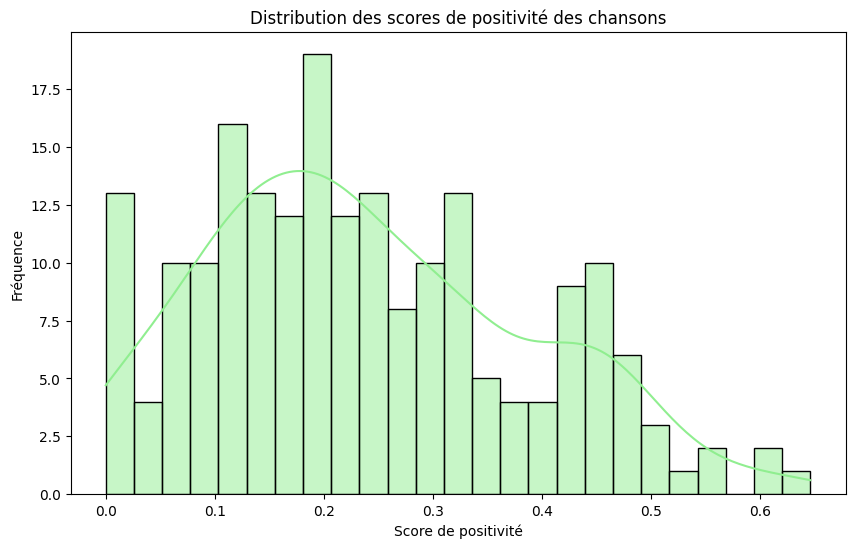

Text(0, 0.5, 'Fréquence')

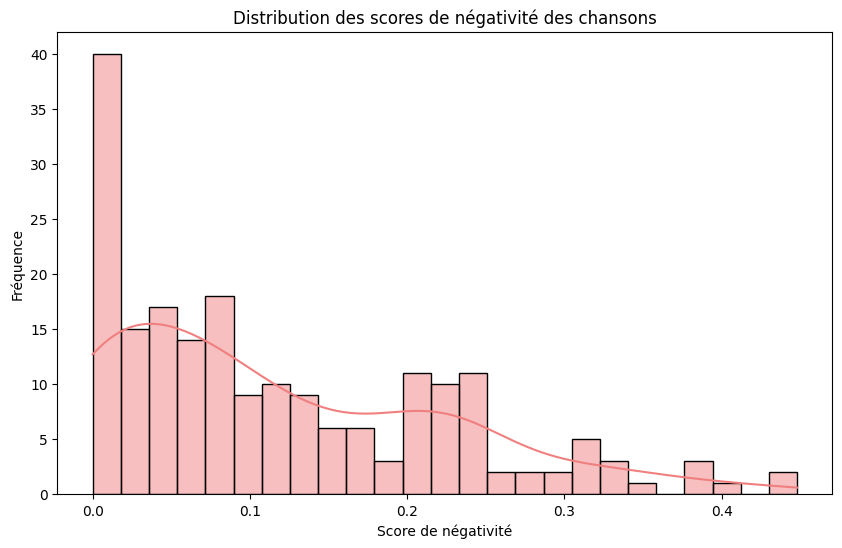

In [29]:
# Affichage d'histogrammes

plt.figure(figsize=(10, 6))
sns.histplot(dataframe['Positive'], kde=True, bins=25, color='lightgreen')
plt.title('Distribution des scores de positivité des chansons')
plt.xlabel('Score de positivité')
plt.ylabel('Fréquence')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(dataframe['Negative'], kde=True, bins=25, color='lightcoral')
plt.title('Distribution des scores de négativité des chansons')
plt.xlabel('Score de négativité')
plt.ylabel('Fréquence')

### B) Détermination des mots les plus fréquents dans les paroles des chansons

Notre objectif est maintenant de prédire les paroles les plus populaires. Pour cela, nous allons d'abord distinguer en fonction des tags les mots les plus fréquents dans les paroles des chansons. Cela permettra de générer une chanson dans un style donné, par exemple une chanson pop, r&b, ou même de Noël.

In [30]:
# For each song, put the five most common words in a list and add them to the dataframe
dataframe['TopWords'] = dataframe['LyricsTokenized'].apply(lambda x: [word for word, count in Counter(x).most_common(5)])

dataframe


,Song,Artist,Lyrics,LyricsTokenizedStopWords,LyricsTokenized,LyricsLength,Positive,Negative,Neutral,TopWords
0,APT.,"[Rosé, Bruno Mars]",\r\nChaeyoung-iga\r\n joahaneun\r\nRandom game...,"[joahaneun, random, game, random, game, game, ...","[joahaneun, random, game, random, game, game, ...",305,0.206,0.053,0.741,"[apateu, like, want, need, meet]"
1,All I Want For Christmas Is You,[Mariah Carey],\r\nI don't want a lot for Christmas\r\nThere ...,"[i, do, want, a, lot, for, christmas, there, i...","[want, lot, christmas, one, thing, need, care,...",343,0.327,0.000,0.673,"[want, christmas, baby, make, need]"
2,Last Christmas,[Wham!],"\r\n\r\nAh, ah-ah\r\nOoh-woah\r\nOh-oh\r\n\r\n...","[ah, last, christmas, i, gave, you, my, heart,...","[last, christmas, gave, heart, next, day, gave...",436,0.308,0.128,0.564,"[someone, give, gave, heart, special]"
3,Die With A Smile,"[Lady Gaga, Bruno Mars]","\r\n\r\n\r\nI, I just woke up from a dream\r\n...","[i, i, just, woke, up, from, a, dream, where, ...","[woke, dream, say, goodbye, know, means, since...",294,0.317,0.160,0.523,"[wan, next, world, ending, night]"
4,Rockin' Around The Christmas Tree,[Brenda Lee],\r\nRockin' around the Christmas tree\r\nAt th...,"[rockin, around, the, christmas, tree, at, the...","[rockin, around, christmas, tree, christmas, p...",116,0.392,0.023,0.585,"[christmas, rockin, around, tree, let]"
...,...,...,...,...,...,...,...,...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]","\r\nI've been reading books of old, the legend...","[i, been, reading, books, of, old, the, legend...","[reading, books, old, legends, myths, achilles...",266,0.429,0.050,0.521,"[something, want, like, wan, somebody]"
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R...","\r\nOoh\r\nOoh\r\n\r\nWhite diamonds, 2 a.m., ...","[ooh, ooh, white, diamonds, 2, she, wildin, bi...","[white, diamonds, 2, wildin, bitches, sick, go...",298,0.087,0.326,0.587,"[walk, bitch, know, first, might]"
197,Counting Stars,[OneRepublic],"\r\nLately, I've been, I've been losin' sleep\...","[lately, i, been, i, been, losin, sleep, dream...","[lately, losin, sleep, dreamin, things, could,...",519,0.071,0.103,0.826,"[countin, could, burn, river, money]"
198,Lovely,"[Billie Eilish, Khalid]",\r\nThought I found a way\r\nThought I found a...,"[thought, i, found, a, way, thought, i, found,...","[thought, found, way, thought, found, way, nev...",180,0.225,0.155,0.620,"[place, mind, hello, welcome, home]"


In [31]:
# For each tag, find the most common words
tag_words = []
for tag in df_merged['Tags']:
    if tag:
        for word in tag:
            if word not in tag_words:
                tag_words.append(word)
                
print(tag_words)
print(df_merged['Tags'])
                    
# For each tag, find the artists, then the songs, then the most common words
most_common_words = {}
for tag in tag_words:
    artists = df_merged[df_merged['Tags'].apply(lambda x: x is not None and tag in x)]['Artist']
    songs = dataframe[dataframe['Artist'].apply(lambda x: any(artist in x for artist in artists))]['LyricsTokenized']
    words = [word for sublist in songs for word in sublist]
    most_common_words[tag] = Counter(words).most_common(5)
    
most_common_words

['2010s', 'funk', 'music for soccer moms', 'pop', 'r&b', 'relic inn', 'rock', 'soul', '1990s', '2000s', '90s', 'adult contemporary', 'christmas music', 'contemporary r&b', 'dance-pop', 'easy listening', 'english', 'hip hop', 'pop soul', 'quiet storm', 'queer', '2020s', 'americana', 'dance', 'electro house', 'electronic', 'electropop', 'film soundtrack', 'jazz', 'late 2000s', 'pop rock', 'synth-pop', 'synthpop', '2008 universal fire victim', 'american', 'classic pop and rock', 'country', 'rock and roll', 'rockabilly', 'alt-pop', 'alternative pop', 'alternative r&b', 'art pop', 'bedroom pop', 'dark pop', 'indie pop', 'pity pop', 'singer-songwriter', 'trap soul', 'folk pop', 'big band', 'country pop', 'standards', 'traditional pop', 'vocal jazz', 'alternative hip hop', 'conscious hip hop', 'hardcore hip hop', 'jazz rap', 'pop rap', 'rap', 'trap', 'west coast hip hop', 'hip hop soul', 'neo soul', 'easy listening soundtracks and musicals', 'australian', 'baroque pop', 'brill building', 'gir

{'2010s': [('like', 106),
  ('love', 83),
  ('baby', 80),
  ('know', 63),
  ('apateu', 59)],
 'funk': [('apateu', 59),
  ('like', 43),
  ('know', 17),
  ('wan', 17),
  ('want', 15)],
 'music for soccer moms': [('apateu', 59),
  ('like', 55),
  ('come', 45),
  ('love', 35),
  ('baby', 29)],
 'pop': [('like', 280),
  ('baby', 202),
  ('know', 201),
  ('love', 170),
  ('get', 153)],
 'r&b': [('like', 89),
  ('baby', 73),
  ('know', 62),
  ('apateu', 59),
  ('sticky', 59)],
 'relic inn': [('apateu', 59),
  ('like', 50),
  ('want', 16),
  ('wan', 14),
  ('way', 13)],
 'rock': [('like', 103),
  ('christmas', 69),
  ('apateu', 59),
  ('know', 59),
  ('sticky', 59)],
 'soul': [('like', 69),
  ('apateu', 59),
  ('baby', 46),
  ('want', 45),
  ('know', 38)],
 '1990s': [('bye', 33),
  ('baby', 29),
  ('christmas', 19),
  ('wan', 17),
  ('want', 16)],
 '2000s': [('sticky', 59),
  ('baby', 54),
  ('gettin', 39),
  ('wan', 36),
  ('want', 35)],
 '90s': [('bye', 33),
  ('baby', 29),
  ('christmas', 1

### C) Notre tentative: la génération d'un refrain

Nous pouvons désormais utiliser un modèle pré-entraîné (gpt2) pour générer des paroles de chansons. Pour cela, nous avons créé une fonction `generate_meaningful_chorus` qui prend en entrée des mots clés, une longueur de chanson et une température, et renvoie une chanson générée par le modèle. Après avoir testé la génération avec différents paramètres et prompts, nous avons obtenu des résultats intéressants. Par exemple, en utilisant le prompt "Write one meaningful song chorus using some of these words: " suivi des mots clés d'un tag, nous avons obtenu des chansons générées qui respectent le style du tag donné. Ci-dessous, nous avons généré des paroles sur le thème de Noël.

In [33]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Charger un modèle GPT-2 pré-entraîné
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

def generate_meaningful_chorus(keywords, max_length=70, temperature=0.7):
    # Construction du prompt contextuel
    prompt = (
        "Write one meaningful song chorus using some of these words: "
        + ", ".join(keywords) + ".\n\n"
        "Chorus:\n"
    )

    print("Prompt:", prompt)
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Générer du texte
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=3,  # Avoid too much repetition
        top_k=100,  # Broader pool of tokens
        top_p=0.9,  # Allow only likely tokens
        temperature=temperature,  # Reduce randomness
        early_stopping=True
    )

    
    # Décoder la sortie
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    # Extraire uniquement le texte généré après le prompt
    chorus = generated_text[len(prompt):].strip()
    return chorus


style = "christmas music"
keywords = [word for word, count in most_common_words[style]]
print("Keywords:", keywords)
chorus = generate_meaningful_chorus(keywords)
print(chorus)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\generation\configuration_utils.py:628: UserWarning:

`do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\generation\configuration_utils.py:633: UserWarning:

`do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based g

Keywords: ['christmas', 'jingle', 'santa', 'baby', 'time']
Prompt: Write one meaningful song chorus using some of these words: christmas, jingle, santa, baby, time.

Chorus:

1. "I'm a baby, I'm a christmas girl, I love you, I want to be with you, and I want you to be my baby."

2.
